In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import functools
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds
from models_adl4cv.pvcnn import PVCNNUp
from models_adl4cv.loss import get_repulsion_loss4

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud

# Prepare Datasets and DataLoaders

In [4]:
NPOINTS = 2048 * 2
CATEGORY = "chair"

In [5]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='train',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='val',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=[CATEGORY], split='test',
    tr_sample_size=NPOINTS,
    te_sample_size=NPOINTS,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)4096 (test)4096
Total number of data:662
Min number of points: (train)4096 (test)4096
Total number of data:1317
Min number of points: (train)4096 (test)4096


In [6]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [7]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

In [8]:
def add_random_noise(point_cloud, mean=0, std=0.05):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [9]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [10]:
def EMD_loss(a,b):
    return EMD(a,b, transpose=False).mean()

In [11]:
def combined_loss(input, output):
    # Expects output of shape: [B, N, C]
    emd_loss = EMD_loss(input, output)
    repulsion_loss = get_repulsion_loss4(output)

    # Same as in https://github.com/yulequan/PU-Net/blob/master/code/model_utils.py
    return 100 * emd_loss + repulsion_loss

In [12]:
def subsample(pc, npoints=2048):
    # pc: [B, N, C] N <= npoints
    _, N, _ = pc.shape
    assert npoints <= N

    idx = np.random.choice(N, npoints)
    return pc[:,idx,:]

In [13]:
model = PVCNNUp(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")

In [14]:
noise = torch.normal(0, 1, size=(20, 4096, 3))
subsampled_noise = subsample(noise)

noise.shape, subsampled_noise.shape

(torch.Size([20, 4096, 3]), torch.Size([20, 2048, 3]))

In [15]:
noise = torch.normal(0, 1, size=(20, 4096, 3)).to("cuda")
noise_subsample = subsample(noise)
output = model(noise_subsample.transpose(1,2)).transpose(1,2)

noise.shape, output.shape

(torch.Size([20, 4096, 3]), torch.Size([20, 4096, 3]))

In [16]:
emd_loss = EMD_loss(noise, output)
emd_loss

tensor(2.5129, device='cuda:0', grad_fn=<MeanBackward0>)

In [17]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Upsample-Global-Chair'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [18]:
# TODO: Maybe we can use a pre-trained PVCNN-Residual to denoise the input
# and then use a second model that upsamples the denoised input.


for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")

        input_downsampled = subsample(input)
        # Add noise to the input
        noised_downsampled_input = add_random_noise(input_downsampled).transpose(1,2)
        
        optimizer.zero_grad()
        output = model(noised_downsampled_input).to("cuda").transpose(1,2)
        
        loss = combined_loss(input, output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)


    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")

            input_downsampled = subsample(input)
            # Add noise to the input
            noised_downsampled_input = add_random_noise(input_downsampled).transpose(1,2)
            output = model(noised_downsampled_input).to("cuda").transpose(1,2)
            
            val_loss = combined_loss(input, output)

            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 80.7641, Validation Loss: 46.5946
Epoch 2,  Training Loss: 26.8096, Validation Loss: 28.5269
Epoch 3,  Training Loss: 22.3763, Validation Loss: 23.4631
Epoch 4,  Training Loss: 20.8738, Validation Loss: 22.2543
Epoch 5,  Training Loss: 19.8267, Validation Loss: 19.7756
Epoch 6,  Training Loss: 18.9676, Validation Loss: 19.7561
Epoch 7,  Training Loss: 18.6928, Validation Loss: 19.9622
No improvement in validation loss for 1 epochs.
Epoch 8,  Training Loss: 18.7161, Validation Loss: 18.8177
Epoch 9,  Training Loss: 18.4501, Validation Loss: 18.9385
No improvement in validation loss for 1 epochs.
Epoch 10,  Training Loss: 18.0540, Validation Loss: 17.4161
Epoch 11,  Training Loss: 17.9405, Validation Loss: 17.5651
No improvement in validation loss for 1 epochs.
Epoch 12,  Training Loss: 17.9968, Validation Loss: 17.5946
No improvement in validation loss for 2 epochs.
Epoch 13,  Training Loss: 17.6723, Validation Loss: 18.1684
No improvement in validation loss for

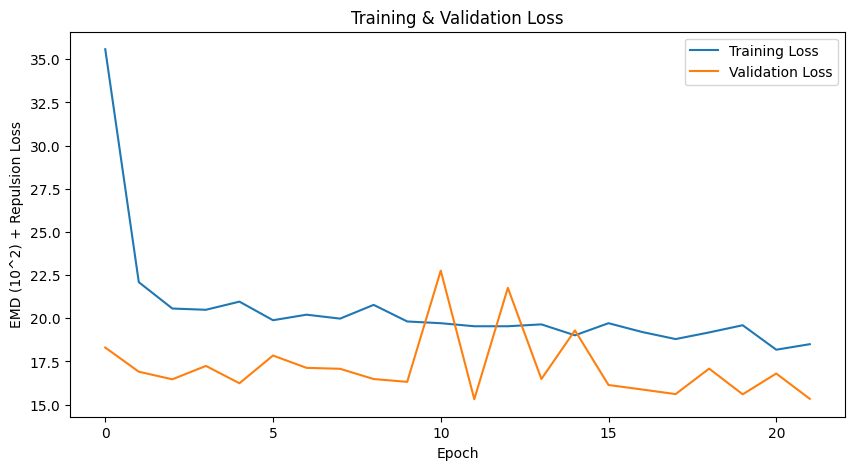

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('EMD (10^2) + Repulsion Loss')
plt.legend()
plt.show()

torch.Size([4096, 3]) torch.Size([2048, 3]) torch.Size([4096, 3])


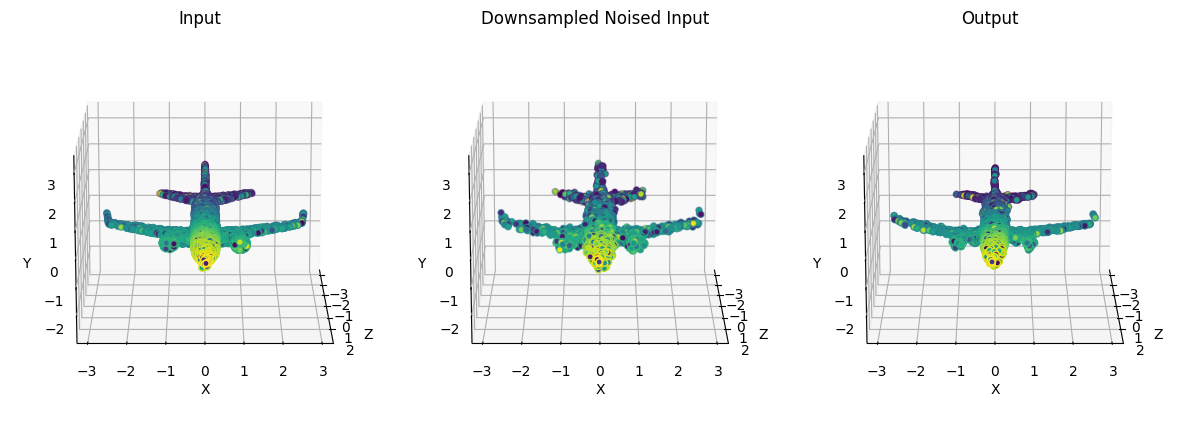

In [35]:
INDEX = 0
input_pc = input[INDEX, ...].detach()
noised_input_pc = noised_downsampled_input[INDEX, ...].detach().transpose(0,1)
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, noised_input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval_three(input_pc, noised_input_pc, output_pc, 
                                "Input", "Downsampled Noised Input", "Output")

# Let's visualize some examples

In [14]:
# Run this if you need to load the model.

model = PVCNNUp(num_classes=3, num_shapes=3, extra_feature_channels=0).to("cuda")
model.load_state_dict(torch.load("output-models/pvcnn-upsample-global-chair/PVCNN-Upsample-Global-Chair-e33.pth"))

<All keys matched successfully>

# Evaluate the trained PVCNN

In [15]:
model.eval()

total_test_loss = 0

input_arr = []
output_arr = []

for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        input_downsampled = subsample(input)
        # Add noise to the input
        noised_downsampled_input = add_random_noise(input_downsampled).transpose(1,2)
        output = model(noised_downsampled_input).to("cuda").transpose(1,2)
        
        input_arr.append(input)
        output_arr.append(output)

        loss = combined_loss(input, output)
        total_test_loss += loss.item()
        print(f"Batch {i}, EMD + Repulsion Loss: {loss.item():.4f}")

average_loss = total_test_loss / len(test_dataloader)
print(f"TOTAL CD Loss: {average_loss:.4f}")

Batch 0, EMD + Repulsion Loss: 16.6907
Batch 1, EMD + Repulsion Loss: 17.0731
Batch 2, EMD + Repulsion Loss: 15.0745
Batch 3, EMD + Repulsion Loss: 16.5015
Batch 4, EMD + Repulsion Loss: 18.4626
Batch 5, EMD + Repulsion Loss: 15.4458
Batch 6, EMD + Repulsion Loss: 15.7684
Batch 7, EMD + Repulsion Loss: 17.0841
Batch 8, EMD + Repulsion Loss: 19.2741
Batch 9, EMD + Repulsion Loss: 16.0616
Batch 10, EMD + Repulsion Loss: 15.8252
Batch 11, EMD + Repulsion Loss: 14.6366
Batch 12, EMD + Repulsion Loss: 16.6631
Batch 13, EMD + Repulsion Loss: 18.1511
Batch 14, EMD + Repulsion Loss: 17.3769
Batch 15, EMD + Repulsion Loss: 15.6331
Batch 16, EMD + Repulsion Loss: 16.0022
Batch 17, EMD + Repulsion Loss: 17.0410
Batch 18, EMD + Repulsion Loss: 17.1334
Batch 19, EMD + Repulsion Loss: 14.6696
Batch 20, EMD + Repulsion Loss: 17.1796
Batch 21, EMD + Repulsion Loss: 15.4775
Batch 22, EMD + Repulsion Loss: 19.1346
Batch 23, EMD + Repulsion Loss: 17.0686
Batch 24, EMD + Repulsion Loss: 14.2803
Batch 25, 

# Let's now try to imrpove the dataset of PVD

In [16]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=[CATEGORY], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [17]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [18]:
model.eval()

output_array = []
for batch in dataloader_pvd:
    with torch.no_grad():
        input = batch["train_points"].to("cuda")

        input_downsampled = subsample(input)
        # Add noise to the input
        noised_downsampled_input = add_random_noise(input_downsampled).transpose(1,2)
        output = model(noised_downsampled_input).to("cuda").transpose(1,2)
        
        output_array.append(output)

In [46]:
len(input_array), len(output_array)

(20, 20)

In [47]:
input_pcs = torch.stack(input_array[:20]).view(400, NPOINTS, 3)
output_pcs = torch.stack(output_array).view(400, NPOINTS, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 4096, 3]), torch.Size([400, 4096, 3]))

In [51]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

  0%|          | 0/400 [00:00<?, ?it/s]

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance


 20%|██        | 80/400 [02:56<11:47,  2.21s/it]

KeyboardInterrupt: 

In [ ]:
airplane = {
    "lgan_mmd-CD": 0.09796344488859177,
    "lgan_cov-CD": 0.5224999785423279,
    "lgan_mmd_smp-CD": 0.110411636531353,
    "lgan_mmd-EMD": 0.5672953128814697,
    "lgan_cov-EMD": 0.5450000166893005,
    "lgan_mmd_smp-EMD": 0.6092360615730286,
    "1-NN-CD-acc_t": 0.5575000047683716,
    "1-NN-CD-acc_f": 0.6075000166893005,
    "1-NN-CD-acc": 0.5824999809265137,
    "1-NN-EMD-acc_t": 0.5400000214576721,
    "1-NN-EMD-acc_f": 0.5849999785423279,
    "1-NN-EMD-acc": 0.5625,
}

# NNA-CD: 58.25%
# NNA-EMD: 56.0%

torch.Size([2048, 3]) torch.Size([4096, 3])


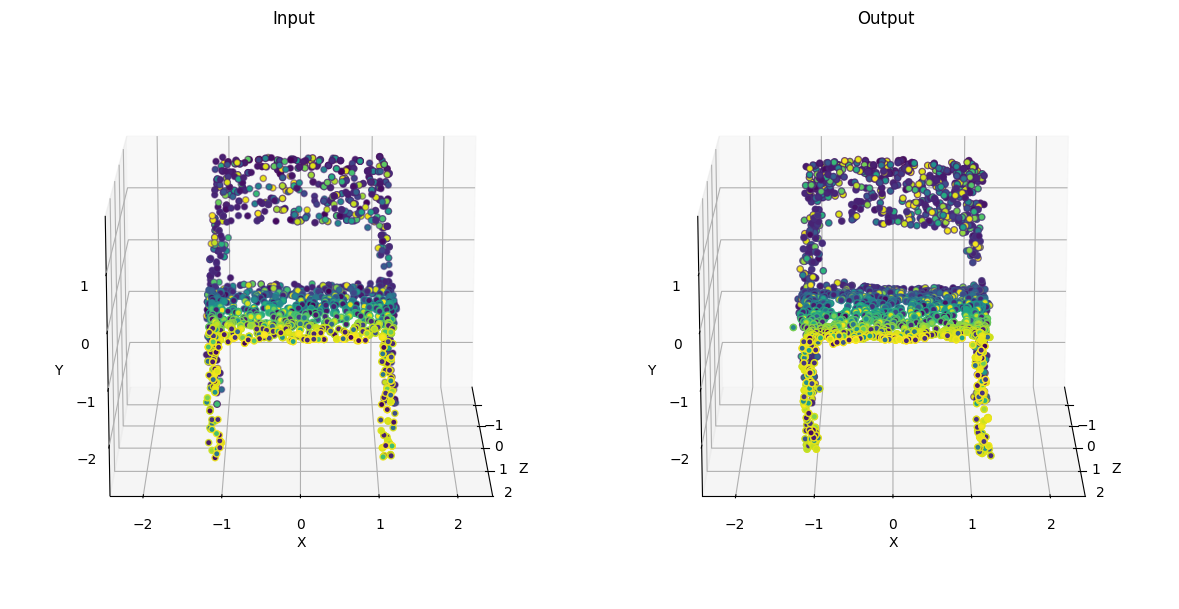

In [20]:
INDEX = 2
input_pc = input[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
print(input_pc.shape, output_pc.shape)

fig = visualize_pointcloud_eval(input_pc, output_pc, "Input", "Output")

In [24]:
chamfer_distance(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.0051, device='cuda:0')

In [25]:
EMD_loss(input_pc.unsqueeze(0), output_pc.unsqueeze(0))

tensor(0.2686, device='cuda:0')

In [27]:
get_repulsion_loss4(output_pc.unsqueeze(0))

tensor(0.0700, device='cuda:0')

In [21]:
from visuals.mitsuba_vis import render_mitsuba
import matplotlib.pyplot as plt

input_img = render_mitsuba(input_pc.cpu().numpy(), "./input.xml", fov=15)
output_img = render_mitsuba(output_pc.cpu().numpy(), "./output.xml", fov=15)

Center: [-0.0110774  -0.44897377 -0.56659156], Scale: 4.673626899719238
Center: [-0.00890225 -0.4681896  -0.52000207], Scale: 4.644590377807617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


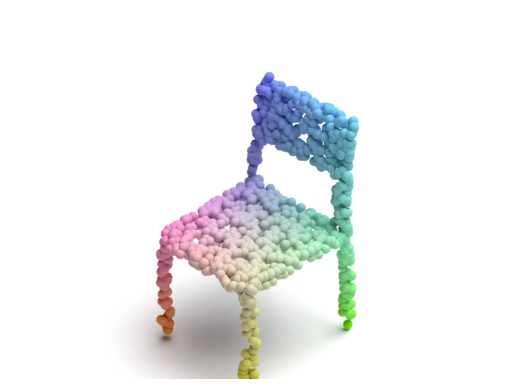

In [22]:
plt.axis("off")
plt.imshow(input_img ** (1.0 / 2.2)); # approximate sRGB tonemapping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


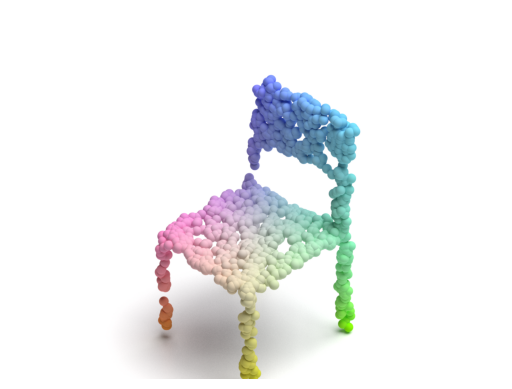

In [23]:
plt.axis("off")
plt.imshow(output_img ** (1.0 / 2.2)); # approximate sRGB tonemapping